## Variational Auto Encoder

A VAE models complicated distribution through a complex deterministic transformation of a simple distribution. Like many other methods ( one of which was discussed in first notebook ), VAE also tries to maximize the log-likelihood of a sample from the target distribution. Particularly, VAEs maximize the variational lower bound to the log-likelihood. During training phase, it also learns an encoder to estimate the variational lower bound. 

VAE can be represented by the following :- 

<img src="images/VAE.png", width="900", align=”left”>



Let's learn an VAE which generates digits from the MNIST dataset.

In [1]:
################
# import modules
################

import numpy as np
import matplotlib.pyplot as plt


import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [2]:
# gpu or cpu
cuda = torch.cuda.is_available()

# if gpu is used
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

seed = 1

# dataset related
n_classes = 10
z_dim = 2
X_dim = 784
train_batch_size = 100
val_batch_size = train_batch_size
N = 1000
epochs = 5

# load into a dictionary
params = {}
params['cuda'] = cuda
params['n_classes'] = n_classes
params['z_dim'] = z_dim
params['X_dim'] = X_dim
params['train_batch_size'] = train_batch_size
params['val_batch_size'] = val_batch_size
params['N'] = N
params['epochs'] = epochs

In [3]:
# loading the dataset

transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
    ])

train_dataset = torchvision.datasets.MNIST(root='datasets/', 
                                            train=True, 
                                            transform=transform, 
                                            target_transform=None, 
                                            download=True)
val_dataset = torchvision.datasets.MNIST(root='datasets/',
                                          train=False,
                                          transform = transform,
                                          target_transform=None,
                                          download=True)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=train_batch_size,
                                                   shuffle=True, **kwargs)
val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                                   batch_size=val_batch_size,
                                                   shuffle=True, **kwargs)

In [74]:
# defining the encoder and decoder networks


class QNet(nn.Module):
    '''
    Recoginition Model
    '''
    def __init__(self):
        super(QNet, self).__init__()
        self.layer1 = nn.Linear(X_dim, N)
        self.layer2 = nn.Linear(N,N)
        self.layer3_mean = nn.Linear(N,z_dim)
        self.layer3_var = nn.Linear(N,z_dim)
        
    def forward(self, x):
        x = F.dropout(self.layer1(x), p=0.2)
        x = F.relu(x)
        x = F.dropout(self.layer2(x), p=0.2)
        x = F.relu(x)
        
        x_mean = self.layer3_mean(x)
        x_var = self.layer3_var(x)
        return x_mean, x_var

class PNet(nn.Module):
    '''
    Generative Model
    '''
    def __init__(self):
        super(PNet, self).__init__()
        self.layer1 = nn.Linear(z_dim, N)
        self.layer2 = nn.Linear(N, N)
        self.layer3 = nn.Linear(N, X_dim)
    
    def forward(self, x):
        x = F.dropout(self.layer1(x), p=0.2)
        x = F.relu(x)
        x = F.dropout(self.layer2(x), p=0.2)
        x = F.relu(x)
        x = F.sigmoid(self.layer3(x))
        return x

From the previous notebook, we derived the objective that we need to optimise

$$ \mathcal{L}_{ELBO}(q,\theta)  =  \int q(z)\ln\frac{p(x|z,\theta)}{q(z)} dz = \int q(z)\ln\frac{p(x|z,\theta)p(z)}{q(z)} dz  = \mathbb{E}_{q(z)} [\ln p(x|z,\theta)] - KL(q(z)||p(z)) $$

In [96]:
# train function

def train(data_loader, epochs = 10):
    
    torch.manual_seed(10)

    if cuda:
        encoder = QNet().cuda()
        decoder = PNet().cuda()
    else:
        encoder = QNet()
        decoder = PNet()
    
    encoder.train()
    decoder.train()
    
    # set the gradient to 0
    encoder.zero_grad()
    decoder.zero_grad()
    
    # set a learning rate
    lr = 0.0005
    
    # define a optimiser, usually Adam
    encoder_optimiser = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimiser = optim.Adam(decoder.parameters(), lr=lr)
    

    for epoch in range(epochs):
        for i,data in enumerate(data_loader):

            # reshape the image from 28x28 to 784
            x = data[0].view(-1,784)

            # convert to pytorch variable
            x = Variable(x)
            # convert to gpu mode
            if cuda:
                x = x.cuda()

            # mean a std. of latent distribution

            # assume it is log-variance
            z_mu, z_sigma = encoder(x)

            # converting log variance to variance
            z_sigma = (0.5*z_sigma).exp()

            # sampling using the reparamatrization trick
            epsilon = torch.randn(z_sigma.size())
            if cuda:
                epsilon = epsilon.cuda()
            epsilon = Variable(epsilon)

            sample = z_mu+epsilon*z_sigma


            # reconstruct through generative network
            x_cap = decoder(sample)


            # loss function = reconstruction loss + KL divergence loss
            # reconstruction loss
            criterian = nn.BCELoss()
            
            recon_loss = criterian(x_cap, x)
            
            # KL divergence loss
            KL_loss = -(0.5)*(1+z_sigma-z_sigma.exp()-z_mu*z_mu)
            KL_loss = torch.sum(KL_loss)

            total_loss = KL_loss + recon_loss

            total_loss.backward()
            encoder_optimiser.step()
            decoder_optimiser.step()

            # ensure that the gradients are reset to zero
            encoder.zero_grad()
            decoder.zero_grad()
            
        # print the loss after each epoch 
        print ("Epoch: {} Reconstriction Loss : {:.4} KL Divergence Loss : {:.4}".format(epoch+1, recon_loss.data, KL_loss.data))
        
    # save the trained encoder and decoder
    torch.save(encoder.state_dict(), './models/encoder.pt')
    torch.save(decoder.state_dict(), './models/decoder.pt')

In [97]:
train(train_data_loader)

Epoch: 1 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 2 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 3 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 4 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 5 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 6 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 7 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 8 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 9 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0
Epoch: 10 Reconstriction Loss : 
-6. KL Divergence Loss : 
1.0


In [145]:
# reconstruct the images from validation set

def reconstruct():
    
    encoder = QNet()
    decoder = PNet()
    
    if cuda:
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    
    encoder.load_state_dict(torch.load('./models/encoder.pt'))
    decoder.load_state_dict(torch.load('./models/decoder.pt'))
    
    
    encoder.eval()
    decoder.eval()
    
    for i,data in enumerate(val_data_loader):
        break
    
    # select the first element
    
    x = data[0].view(-1,784)
    x = Variable(x)
    if cuda:
        x = x.cuda()
    
    
    # sample from the latent distribution
    
    z_mean, z_sigma = encoder(x)
    z_sigma = (0.5*z_sigma).exp()
    
    epsilon = torch.randn(z_sigma.size())
    epsilon = Variable(epsilon)
    if cuda:
        epsilon = epsilon.cuda()
    
    sample = z_mean + z_sigma*epsilon
    
    x_cap = decoder(sample)
    
    original = x.data.numpy().reshape(-1,28,28)
    reconstruction = x_cap.data.numpy().reshape(-1,28,28)
        
    # plot the images
    plt.subplot(1,2,1)
    plt.imshow(original[0])
    plt.subplot(1,2,2)
    plt.imshow(reconstruction[0])
    plt.show()

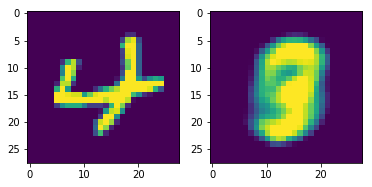

In [146]:
reconstruct()